# Import

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

seed = 1
tf.random.set_seed(seed)

# Make dataset for train

In [2]:
# read_csv

path = "../dataset/data/Media/"
data1 = pd.read_csv(path + "Media_INFO.csv")
data2 = pd.read_csv(path + "Media_LOGIN.csv")
data3 = pd.read_csv(path + "Media_MENU.csv")
data4 = pd.read_csv(path + "Media_STREAM.csv")

data1.reset_index(inplace=True, drop=True)
data2.reset_index(inplace=True, drop=True)
data3.reset_index(inplace=True, drop=True)
data4.reset_index(inplace=True, drop=True)

In [3]:
# drop na, column

data1.drop(["INFO-01-Fail", "Timestamp"], axis=1, inplace=True)
data2.drop(["Timestamp"], axis=1, inplace=True)
data3.drop(["Timestamp"], axis=1, inplace=True)
data4.drop(["Timestamp"], axis=1, inplace=True)

data1.dropna(inplace=True)
data2.dropna(inplace=True)
data3.dropna(inplace=True)
data4.dropna(inplace=True)

server1 = data1
server2 = data2.iloc[:, [0, 1, 2]]
server3 = data2.iloc[:, [3, 4, 5]]
server4 = data2.iloc[:, [6, 7, 8]]
server5 = data2.iloc[:, [9, 10, 11]]
server6 = data2.iloc[:, [12, 13, 14]]
server7 = data3.iloc[:, [0, 1, 2]]
server8 = data3.iloc[:, [3, 4, 5]]
server9 = data3.iloc[:, [6, 7, 8]]
server10 = data3.iloc[:, [9, 10, 11]]
server11 = data4.iloc[:, [0]]
server12 = data4.iloc[:, [1]]
server13 = data4.iloc[:, [2]]

In [4]:
for i in range(13):
    print(globals()[f"server{i + 1}"].shape)

(192249, 2)
(192189, 3)
(192189, 3)
(192189, 3)
(192189, 3)
(192189, 3)
(209771, 3)
(209771, 3)
(209771, 3)
(209771, 3)
(178730, 1)
(178730, 1)
(178730, 1)


In [5]:
# remove outlier


def remove_outlier(df, column):
    Q1 = np.percentile(df[column].values, 25)
    Q3 = np.percentile(df[column].values, 75)

    IQR = Q3 - Q1
    weight = IQR * 1.5

    lowest = Q1 - weight
    highest = Q3 + weight

    outlier_idx = df[column][(df[column] < lowest) | (df[column] > highest)].index
    df.drop(outlier_idx, axis=0, inplace=True)

    return df

In [6]:
for i in range(13):
    column_list = list(globals()[f"server{i + 1}"].columns)
    for j in column_list:
        remove_outlier(globals()[f"server{i + 1}"], j)

/var/folders/qd/yc_92c9d2csclp39hh5l_t900000gn/T/ipykernel_13316/75505299.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(outlier_idx, axis=0, inplace=True)


In [7]:
for i in range(13):
    print(globals()[f"server{i + 1}"].shape)

(188513, 2)
(170651, 3)
(170739, 3)
(170815, 3)
(170750, 3)
(170718, 3)
(198213, 3)
(198233, 3)
(198221, 3)
(198162, 3)
(178534, 1)
(178730, 1)
(173192, 1)


In [8]:
server_df = pd.concat([server1, server2], axis=1)
for i in range(11):
    server_df = pd.concat([server_df, globals()[f"server{i + 3}"]], axis=1)

In [9]:
server_df = server_df.dropna().reset_index(drop=True)
print(server_df.shape)

(142384, 32)


## Transform to sequence

In [10]:
def to_seq(df, step):
    output = []
    for i in range(len(df) - step - 1):
        temp = []
        for j in range(1, step + 1):
            temp.append(df.loc[[(i + j + 1)], :])
        output.append(temp)
    return np.squeeze(np.array(output))

In [11]:
step = abs(5)
trans_server_df = to_seq(server_df, step)
trans_server_df.shape

(142378, 5, 32)

In [12]:
train, valid = train_test_split(trans_server_df, test_size=0.2)
print(train.shape)
print(valid.shape)

(113902, 5, 32)
(28476, 5, 32)


## feature scale

In [15]:
def dimension_down(df):
    dimension_df = np.empty((df.shape[0], df.shape[2]))
    for i in range(df.shape[0]):
        dimension_df[i] = df[i, (df.shape[1] - 1), :]

    return dimension_df


def scaling(df, scaler):
    for i in range(df.shape[0]):
        df[i, :, :] = scaler.transform(df[i, :, :])

    return df

In [13]:
scaler = MinMaxScaler().fit(dimension_down(trans_server_df))
train_scaled = scaling(trans_server_df, scaler)

print(train_scaled.shape)

(142378, 5, 32)


## LSTM AE for trainset

In [16]:
def lstm_autoencoder():
    feature_number = train_scaled.shape[2]
    lstm_ae = models.Sequential()

    # Encoding
    lstm_ae.add(
        layers.LSTM(
            64,
            activity_regularizer=regularizers.L2(0.01),
            activation="relu",
            input_shape=(step, feature_number),
            return_sequences=True,
        ),
    )
    lstm_ae.add(layers.Dropout(rate=0.2)),
    lstm_ae.add(
        layers.LSTM(
            32,
            activity_regularizer=regularizers.L2(0.01),
            activation="relu",
            return_sequences=False,
        )
    )
    lstm_ae.add(layers.RepeatVector(step))

    # Decoding
    lstm_ae.add(
        layers.LSTM(
            32,
            activity_regularizer=regularizers.L2(0.01),
            activation="relu",
            return_sequences=True,
        )
    )
    lstm_ae.add(layers.Dropout(rate=0.2)),
    lstm_ae.add(
        layers.LSTM(
            64,
            activity_regularizer=regularizers.L2(0.01),
            activation="relu",
            return_sequences=True,
        )
    )
    lstm_ae.add(layers.TimeDistributed(layers.Dense(feature_number)))

    print(lstm_ae.summary())
    return lstm_ae

In [17]:
lstm_ae0 = lstm_autoencoder()

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-10 09:36:35.601156: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-10 09:36:35.602151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             24832     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 5, 32)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 5, 32)             8320      
                                                                 
 dropout_1 (Dropout)         (None, 5, 32)             0         
                                                        

In [18]:
# set parameter

epochs = 10
batch_size = 128
learning_rate = 0.001
validation = 0.2

In [19]:
# compile

lstm_ae0.compile(loss="mse", optimizer=optimizers.Adam(learning_rate))

In [1]:
# fit

history = lstm_ae0.fit(
    train_scaled,
    train_scaled,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=validation,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, mode="min")
    ],
)

NameError: name 'lstm_ae0' is not defined

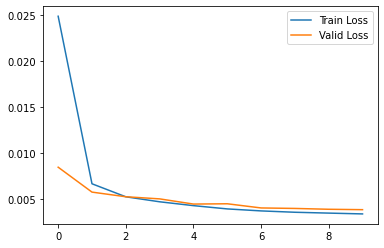

In [20]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Valid Loss")
plt.legend()
plt.show()

In [21]:
predictions = lstm_ae0.predict(test_scaled)

NameError: name 'test_scaled' is not defined

In [82]:
threshold = 0.3

In [83]:
mse = []
for i in range(len(test_scaled)):
    mse.append(
        np.sqrt(
            np.mean(
                np.power(
                    predictions.reshape(
                        predictions.shape[0],
                        predictions.shape[1] * predictions.shape[2],
                    )[i]
                    - test_scaled.reshape(
                        predictions.shape[0],
                        predictions.shape[1] * predictions.shape[2],
                    )[i],
                    2,
                )
            )
        )
    )

In [84]:
predict = []
for i in range(len(mse)):
    if mse[i] > threshold:
        predict.append(1)
    else:
        predict.append(0)

In [85]:
print(pd.DataFrame(predict).value_counts())

0    140621
1      1757
dtype: int64


In [88]:
predict = pd.DataFrame(predict, columns=["prediction"])
drop_list = list(predict[predict["prediction"] == 1].index)

In [152]:
normal_df = server_df.drop(drop_list, axis=0)
normal_df = normal_df.drop(["index"], axis=1)
normal_df.reset_index(inplace=True, drop=True)

# Prepare dataset for test

In [22]:
test = pd.read_csv("../2_test.csv")
test = test.drop(["Unnamed: 0", "Timestamp", "INFO-01-Fail"], axis=1)

## Transform to sequence

In [23]:
trans_test = to_seq(test, step)
print(trans_test.shape)

(105114, 5, 32)


## feature scale

In [24]:
trans_server_df = to_seq(server_df, step)
scaler = MinMaxScaler().fit(dimension_down(trans_server_df))
test_scaled = scaling(trans_test, scaler)
print(test_scaled.shape)

(105114, 5, 32)


# detect anormal

## train mse loss

In [14]:
train_predict = lstm_ae0.predict(train_scaled)

NameError: name 'lstm_ae0' is not defined

## test mse loss

In [25]:
test_predict = lstm_ae0.predict(test_scaled)

2022-05-10 00:24:53.413328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [118]:
mse_loss = np.mean(np.power(test_predict - test_scaled, 2), axis=1)

In [133]:
mean_mse_loss = np.mean(np.mean(np.power(test_predict - test_scaled, 2), axis=1), axis=1)

In [134]:
pd.DataFrame(mean_mse_loss).to_csv("mse_loss.csv", mode="w")

## k-means for set threshold

## put anomalies

In [123]:
train_mse_loss = np.mean(np.power(train_predict - train_scaled, 2), axis=1)
threshold = np.max(train_mse_loss)

reshape_mse_loss = mse_loss.reshape(-1)
anormals = reshape_mse_loss > threshold

In [124]:
anormal_index = []
for i in range(step - 1, len(test) - step + 1):
    if np.all(anormals[i - step + 1 : i]):
        anormal_index.append(i)

In [125]:
prediction = pd.DataFrame([0 * _ for _ in range(len(test))], columns=["Prediction"])
prediction.loc[anormal_index, "Prediction"] = 1
prediction.value_counts()

Prediction
0             104889
1                231
dtype: int64

In [127]:
prediction.to_csv('prediction.csv', mode='w')

In [128]:
prediction[prediction['Prediction'] == 1]

,Prediction
71283,1
71284,1
71285,1
71286,1
71287,1
...,...
71677,1
71700,1
71701,1
71706,1
